In [1]:
import sys
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import os
import pandas as pd
import re
import string
import warnings
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from gensim import corpora

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
os.getcwd()
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf
import model_explain.plot as meplot
import model_explain.shap as meshap

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data'

## Load Data

In [2]:
raw_data = pd.read_csv(os.path.join(root_path, "IMDB Dataset.csv"))
data = raw_data[raw_data.review.isnull()==False]
data['label'] = np.where(data['sentiment']=='positive', 1,0)
data = data.drop_duplicates()
data.insert(0, 'index', data.index + 1)

In [3]:
data.head(3)

,index,review,sentiment,label
0,1,One of the other reviewers has mentioned that ...,positive,1
1,2,A wonderful little production. <br /><br />The...,positive,1
2,3,I thought this was a wonderful way to spend ti...,positive,1


## Data Visualization

In [4]:
for idx, row in raw_data.sample(5).iterrows():
    print("review:")
    print(row['review'])
    print()
    print("sentiment:")
    print(row['sentiment'])
    print("================================================================================================================")

review:
What a stupid waste of money! 30,000 square feet of rebuilt ancient Rome, 2 millions cubic meters of 50 feet tall buildings, 10,000 costumes, 2 years of works, an International Ancient History Committee (sic!), some first class actors and actresses . The final result? An empty TV-movie for a single-digit IQ attendance.

sentiment:
negative
review:
Charming in every way, this film is perfect if you're in the mood to feel good. If you love jazz music, it is a must see. If you enjoy seeing loveable characters that make you smile, can bring a tear to your eye and swing like there's no tomorrow this film is for you. If you are looking for an intense, deep, heavy piece of art to be dissected and analyzed perhaps you best stick with something by Darren Aronofsky (in other words - reviewer djjohn lighten up, don't you know a good time when you see one!) My only complaint is that the movie was just too darn short. I guess I'll just have to watch it several more times to get my fill.

se

## Explore Data

In [5]:
data.groupby('sentiment').agg('count')

,index,review,label
sentiment,,,
negative,24698,24698,24698
positive,24884,24884,24884


In [6]:
print('maximum length of reviews:', DataExploration.text_length_summary(data, 'review', 'max'))
print('minimal length of reviews:', DataExploration.text_length_summary(data, 'review', 'min'))
print('average length of reviews:', DataExploration.text_length_summary(data, 'review', 'avg'))
print('median length of reviews:', DataExploration.text_length_summary(data, 'review', 'median'))

maximum length of reviews: 13704
minimal length of reviews: 32
average length of reviews: 1310
median length of reviews: 971.0


In [39]:
positive_review = data[data['sentiment']=='positive']
negative_review = data[data['sentiment']=='negative']
preprocessed_tokens = textClean.pipeline(data['review'][0:500].to_list(), multi_gram = [1], lower_case=True, deacc=False, encoding='utf8',
                                           errors='strict', stem_lemma = 'lemma', tag_drop = ['V'], nltk_stop=True, stop_word_list=['movie','film','movies','films'], 
                                           check_numbers=True, word_length=3, remove_consecutives=True)
pos_tokens = textClean.pipeline(positive_review['review'][0:500].to_list(), multi_gram = [1], lower_case=True, deacc=False, encoding='utf8',
                                           errors='strict', stem_lemma = 'lemma', tag_drop = ['V'], nltk_stop=True, stop_word_list=['movie','film','movies','films'], 
                                           check_numbers=True, word_length=3, remove_consecutives=True)
neg_tokens = textClean.pipeline(negative_review['review'][0:500].to_list(), multi_gram = [1], lower_case=True, deacc=False, encoding='utf8',
                                           errors='strict', stem_lemma = 'lemma', tag_drop = ['V'], nltk_stop=True, stop_word_list=['movie','film','movies','films'], 
                                           check_numbers=True, word_length=3, remove_consecutives=True)


In [41]:
postop10tfidf = tfidf.get_top_n_tfidf_bow(pos_tokens, top_n_tokens = 30)
negtop10tfidf = tfidf.get_top_n_tfidf_bow(neg_tokens, top_n_tokens = 30)
print('top 10 negative review tfidf', negtop10tfidf)
print('top 10 positive review tfidf', postop10tfidf)

top 10 negative review tfidf ['drug', 'charm', 'rat', 'zombie', 'fiction', 'original', 'book', 'animation', 'dragon', 'disney', 'park', 'game', 'adult', 'poorly', 'dumb', 'gary', 'best', 'woman', 'japanese', 'adam', 'curse', 'gore', 'smile', 'indian', 'murder', 'parody', 'express', 'desert', 'bible', 'rape']
top 10 positive review tfidf ['mary', 'musical', 'rock', 'vampire', 'mickey', 'game', 'match', 'hitchcock', 'jane', 'message', 'skeleton', 'novel', 'ghost', 'adventure', 'italian', 'julia', 'war', 'prince', 'copy', 'dance', 'mood', 'disney', 'flynn', 'world', 'house', 'joseph', 'scott', 'monkey', 'police', 'indian']


In [36]:
top10_freq_list = DataExploration.get_topn_freq_bow(preprocessed_tokens, topn = 10)
top10_posfreq_list = DataExploration.get_topn_freq_bow(pos_tokens, topn = 10)
top10_negfreq_list = DataExploration.get_topn_freq_bow(neg_tokens, topn = 10)
print(top10_freq_list)
print(top10_posfreq_list)
print(top10_negfreq_list)

[('like', 83), ('bad', 62), ('time', 61), ('even', 59), ('good', 56), ('scene', 52), ('character', 52), ('well', 50), ('story', 49), ('would', 44)]
[('like', 77), ('well', 66), ('time', 64), ('character', 57), ('good', 52), ('story', 51), ('life', 49), ('really', 48), ('way', 48), ('scene', 47)]
[('like', 89), ('bad', 86), ('would', 60), ('even', 60), ('good', 51), ('watch', 50), ('well', 49), ('story', 47), ('scene', 46), ('time', 45)]


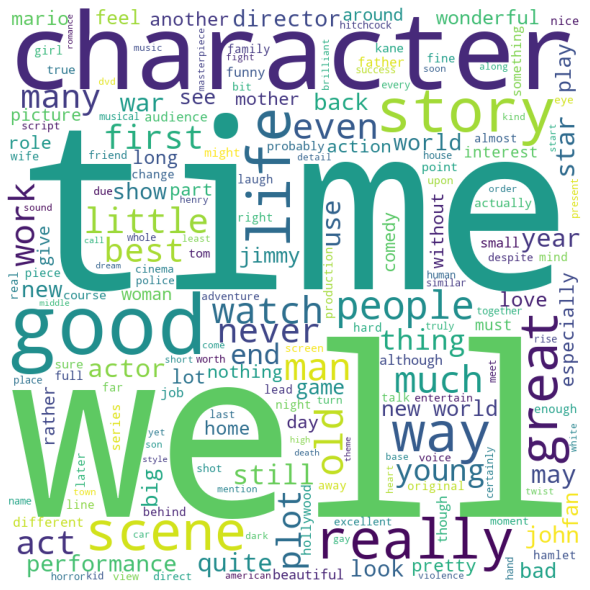

In [37]:
DataExploration.generate_word_cloud(pos_tokens)

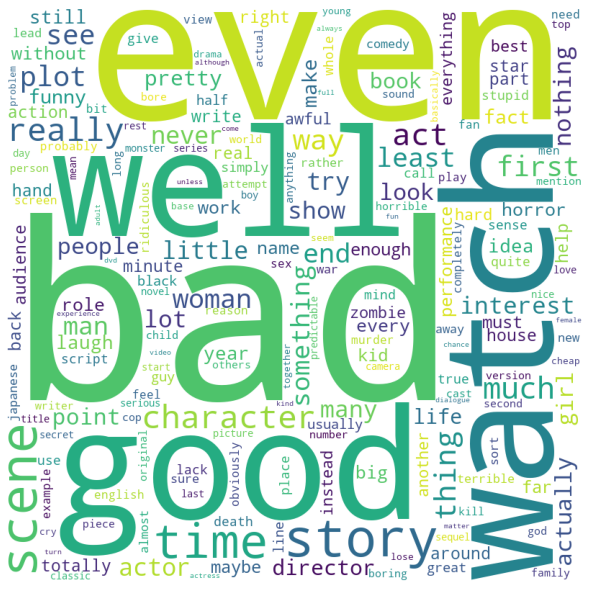

In [38]:
DataExploration.generate_word_cloud(neg_tokens)

## Model Development

### 1. Split Dataset

In [3]:
preprocessed_tokens = textClean.pipeline(data['review'][0:100].to_list(), multi_gram = [1], lower_case=True, deacc=False, encoding='utf8',
                                           errors='strict', stem_lemma = 'lemma', tag_drop = [], nltk_stop=True, stop_word_list=['movie'], 
                                           check_numbers=False, word_length=3, remove_consecutives=True)

dictionary = DocVector.generate_corpus_dict(preprocessed_tokens, no_below =1,
                                            no_above = 0.5, keep_n = 100000)
bow_corpus = DocVector.create_document_vector(preprocessed_tokens, dictionary)
my_df = DocVector.get_vocab_matrix(bow_corpus, dictionary)
my_df.head(3)

,accustom,agenda,agreement,appeal,around,aryan,audience,away,become,bitch,...,rosalina,scatter,shake,spin,superb,travel,upside,via,wii,wiimote
doc,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(my_df.loc[:99,:], data['label'][0:100], test_size = 0.33, random_state = 11)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 11)

### 2. Feature Engineering
* Apart from vectorization process, addtional features can be created from the dataset such as:
    * Length of comments 
    * Number of entities (using Named-Entity Recognition(NER))
    * One-hot encoding of entities
    * Number of positive and negative words (not only meant for sentiment analysis but useful in general)
    * Number of special characters
    * One-hot encoding of special characters
    * Part-of-speech(POS) tags
* Techniques for feature selection to explore:
    * SelectKBest: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
    * Recursive Feature Elimination (RFE): https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

### 3. Preliminary Result

#### Training the model

In [5]:
sentiment_analyzer = RandomForestClassifier()
sentiment_analyzer.fit(X_train, y_train)

RandomForestClassifier()

#### Evaluating the model using 5-Fold CrossValidation

In [15]:
five_fold_accuracy = cross_val_score(sentiment_analyzer, X_train, y_train, cv = 5)
five_fold_accuracy

array([0.54545455, 0.72727273, 0.63636364, 0.6       , 0.6       ])

### 4. Hyperparameter Tuning and New Result
link: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

random forest hypterparameter tuning: https://www.topcoder.com/thrive/articles/understanding-random-forest-and-hyper-parameter-tuning

In [16]:
from sklearn.model_selection import GridSearchCV
grid_parameters = {
    'bootstrap': [True, False],
    'max_depth': [10, 20],# 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600]#, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

In [18]:
# model_param_search = GridSearchCV(sentiment_analyzer, param_grid = grid_parameters, scoring = 'accuracy', cv = 3)
# model_param_search.fit(X_train, y_train)
# model_param_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [16]:
sentiment_analyzer = RandomForestClassifier(bootstrap = True, max_depth = 20, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 200)
sentiment_analyzer.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200)

In [17]:
five_fold_accuracy = cross_val_score(sentiment_analyzer, X_train, y_train, cv = 5)
five_fold_accuracy

array([0.54545455, 0.72727273, 0.63636364, 0.6       , 0.6       ])

#### Addtional Evaluation Metrics

Classification Report

In [18]:
predictions = sentiment_analyzer.predict(X_val)
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.69      1.00      0.82         9
           1       1.00      0.20      0.33         5

    accuracy                           0.71        14
   macro avg       0.85      0.60      0.58        14
weighted avg       0.80      0.71      0.65        14



Confusion Matrix

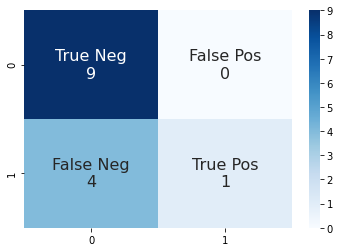

In [19]:
cf_matrix = confusion_matrix(y_val, predictions)
meplot.cf_matrix_heatmap(cf_matrix)

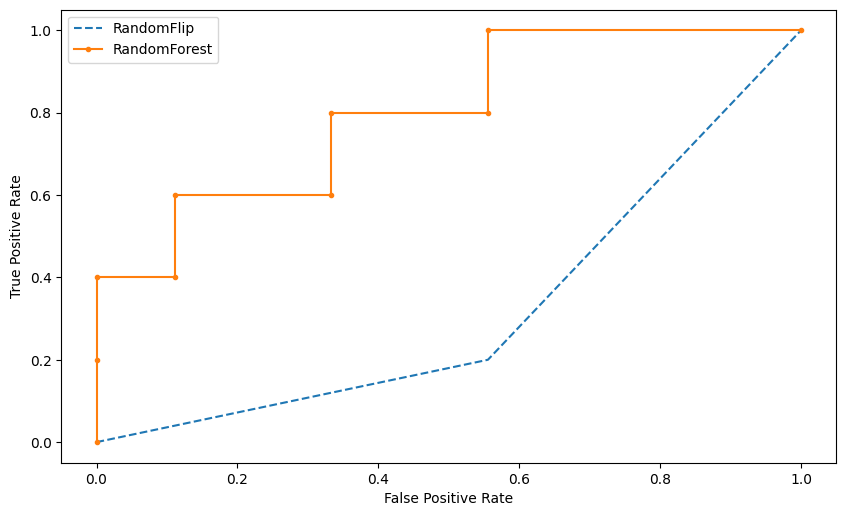

In [20]:
meplot.plot_randomfp_roc(X_train, y_train, X_val, y_val, sentiment_analyzer.predict_proba(X_val)[:,1], model_label = 'RandomForest')    

Reeiver Operating Characteristic (ROC) Curve

#### SHAP

In [6]:
plot, shap_val = meshap.get_tree_SHAP_plot(model = sentiment_analyzer, X = X_val, define_index = False, index_value = 1)
plot

In [7]:
shap_val.head(10)

,SHAP_Value,Sample_value,index_var
heston,0.006258,5.0,1
love,0.005575,0.0,1
home,0.005177,0.0,1
turn,0.004796,0.0,1
scene,0.004756,0.0,1
sure,0.004743,2.0,1
touch,0.004503,1.0,1
become,0.004106,0.0,1
character,0.003974,0.0,1
cinema,0.003850,0.0,1


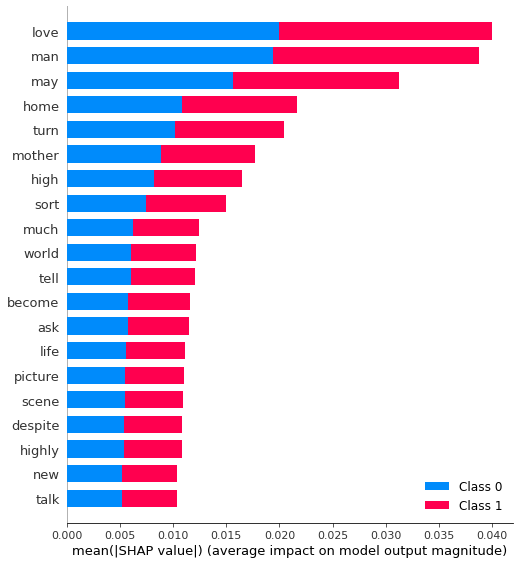

In [8]:
import shap
shap_explainer = shap.TreeExplainer(sentiment_analyzer,X_val)
shap_values = shap_explainer.shap_values(X_val)


shap.summary_plot(shap_values, X_val)

In [23]:
shap.initjs()
def shap_plot(j):
    explainerModel = shap.TreeExplainer(sentiment_analyzer)
    shap_values_Model = explainerModel.shap_values(X_val)
    p = shap.force_plot(explainerModel.expected_value[0], shap_values_Model[0][j], X_val.iloc[[j]])
    print("Review:",data.review[X_val.iloc[[j]].index[0]])
    return(p)

In [24]:
shap_plot(0)

Review: I laughed all the way through this rotten movie. It's so unbelievable. A woman leaves her husband after many years of marriage, has a breakdown in front of a real estate office. What happens? The office manager comes outside and offers her a job!!! Hilarious! Next thing you know the two women are going at it. Yep, they're lesbians! Nothing rings true in this "Lifetime for Women with nothing better to do" movie. Clunky dialogue like "I don't want to spend the rest of my life feeling like I had a chance to be happy and didn't take it" doesn't help. There's a wealthy, distant mother who disapproves of her daughter's new relationship. A sassy black maid - unbelievable that in the year 2003, a film gets made in which there's a sassy black maid. Hattie McDaniel must be turning in her grave. The woman has a husband who freaks out and wants custody of the snotty teenage kids. Sheesh! No cliche is left unturned.


In [47]:
sentiment_analyzer.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

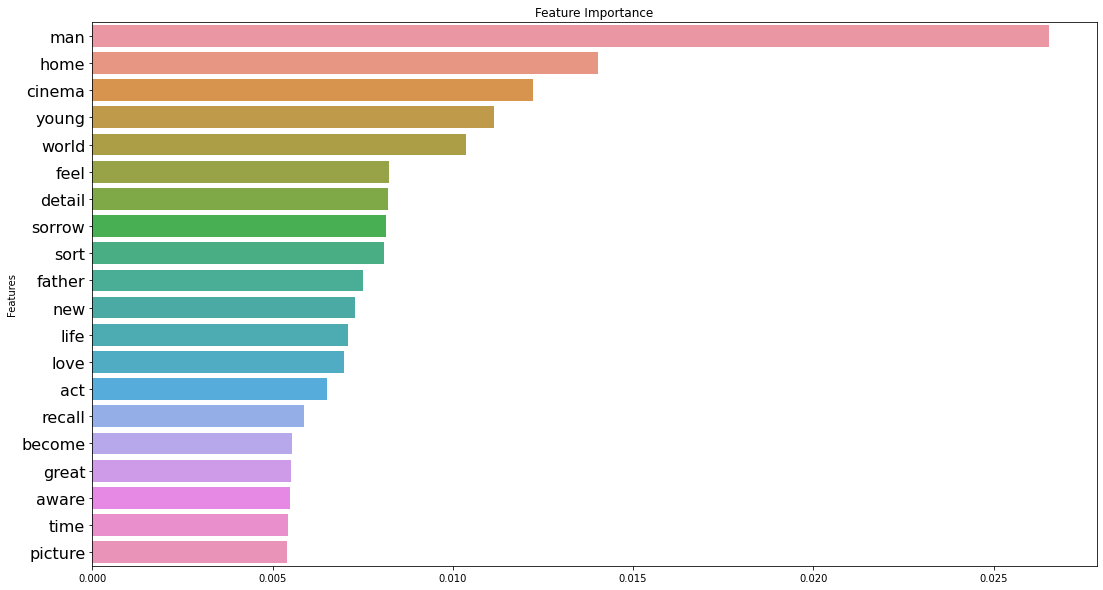

In [48]:
meplot.plot_var_imp(sentiment_analyzer.feature_importances_, X_train.columns, 20)

9972  features


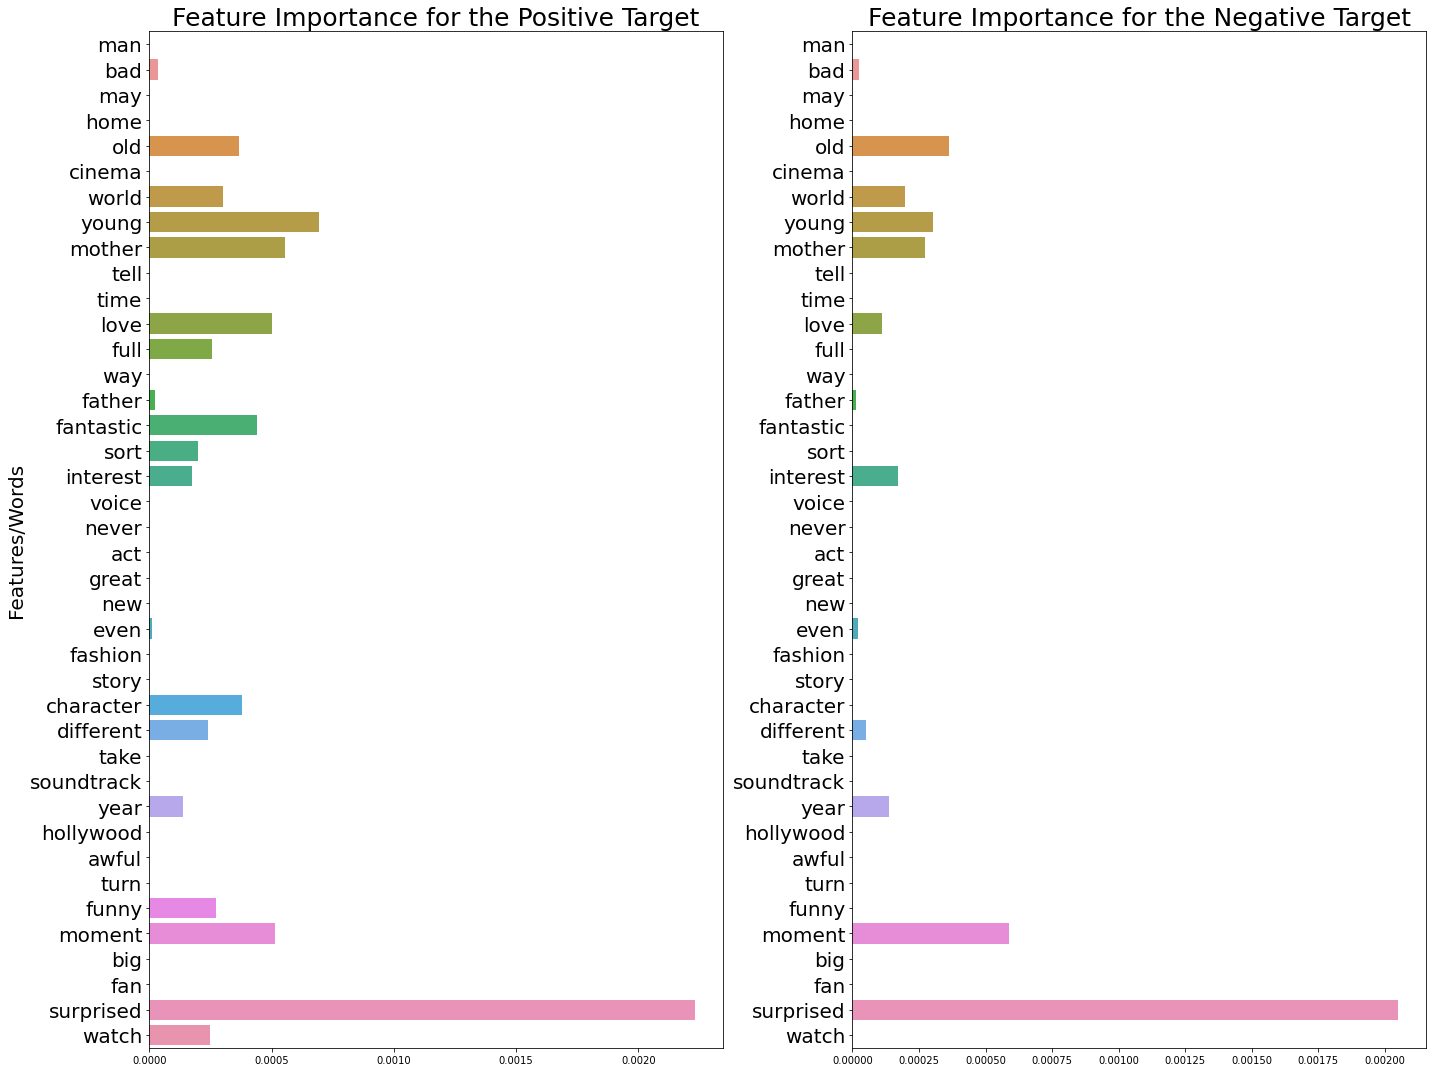

In [27]:
meplot.plot_var_imp_both_side(X_train, y_train, X_train.columns, data, sentiment_analyzer.feature_importances_, topn = 40)

## Pipelines

#### Define Transformer and Pipeline

In [9]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
class TextCleaning(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        preprocessed_tokens = textClean.pipeline(X.to_list(), multi_gram = [1], lower_case=True, deacc=False, encoding='utf8',
                                                 errors='strict', stem_lemma = 'lemma', tag_drop = [], nltk_stop=True, 
                                                 stop_word_list=[], check_numbers=False, word_length=3,
                                                 remove_consecutives=True)
        
        return preprocessed_tokens
                                      
class TextVectors(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
                                    
    def transform(self, X, y=None):

        bow_corpus = DocVector.create_document_vector(X, dictionary)
        my_df = DocVector.get_vocab_matrix(bow_corpus, dictionary)
        return my_df
    

my_pipeline = Pipeline(steps = [
    ('Text Cleaning', TextCleaning()),
    ('Vectorization', TextVectors()),
    ('Prediction', RandomForestClassifier())
])   

#### Access Individual Steps

In [23]:
# processed_doc = my_pipeline['Text Cleaning'].transform(data['review'][0:5000])
# dictionary = DocVector.generate_corpus_dict(processed_doc, no_below =1, no_above = 0.5, keep_n = 100000)
# dictionary.save(os.path.join(root_path,'dictionary.gensim'))

In [10]:
dictionary = corpora.Dictionary.load(os.path.join(root_path,'dictionary.gensim'))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data['review'][0:2000], data['label'][0:2000], test_size = 0.33, random_state = 11)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 11)

In [12]:
my_pipeline.fit(X_train, list(y_train))

Pipeline(steps=[('Text Cleaning', TextCleaning()),
                ('Vectorization', TextVectors()),
                ('Prediction', RandomForestClassifier())])

In [13]:
predictions = my_pipeline.predict(X_val)

#### Model Performance

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       137
           1       0.76      0.89      0.82       131

    accuracy                           0.81       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.81      0.81       268



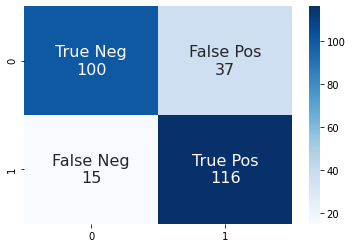

In [14]:
print(classification_report(y_val, predictions))
cf_matrix = confusion_matrix(y_val, predictions)
meplot.cf_matrix_heatmap(cf_matrix)

#### Feature Importance

In [15]:
my_rf_model = my_pipeline['Prediction']
sample_process_doc = my_pipeline['Text Cleaning'].transform(data['review'][0:500])
sample_vec = my_pipeline['Vectorization'].transform(sample_process_doc)
sample_label = list(data['label'])[:500]

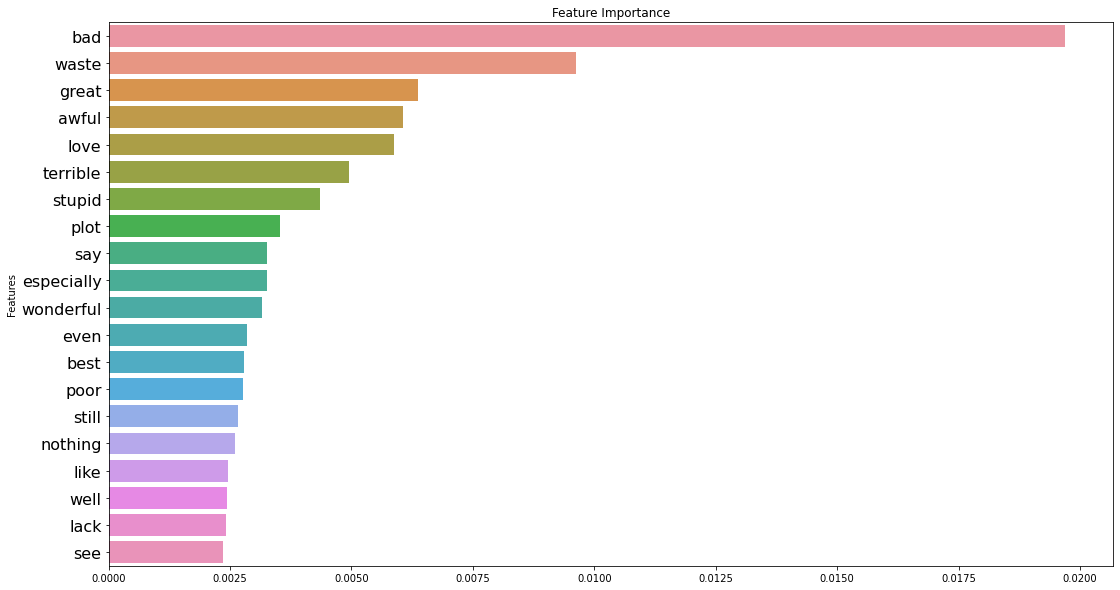

In [16]:
meplot.plot_var_imp(my_rf_model.feature_importances_, sample_vec.columns, 20)

42919  features


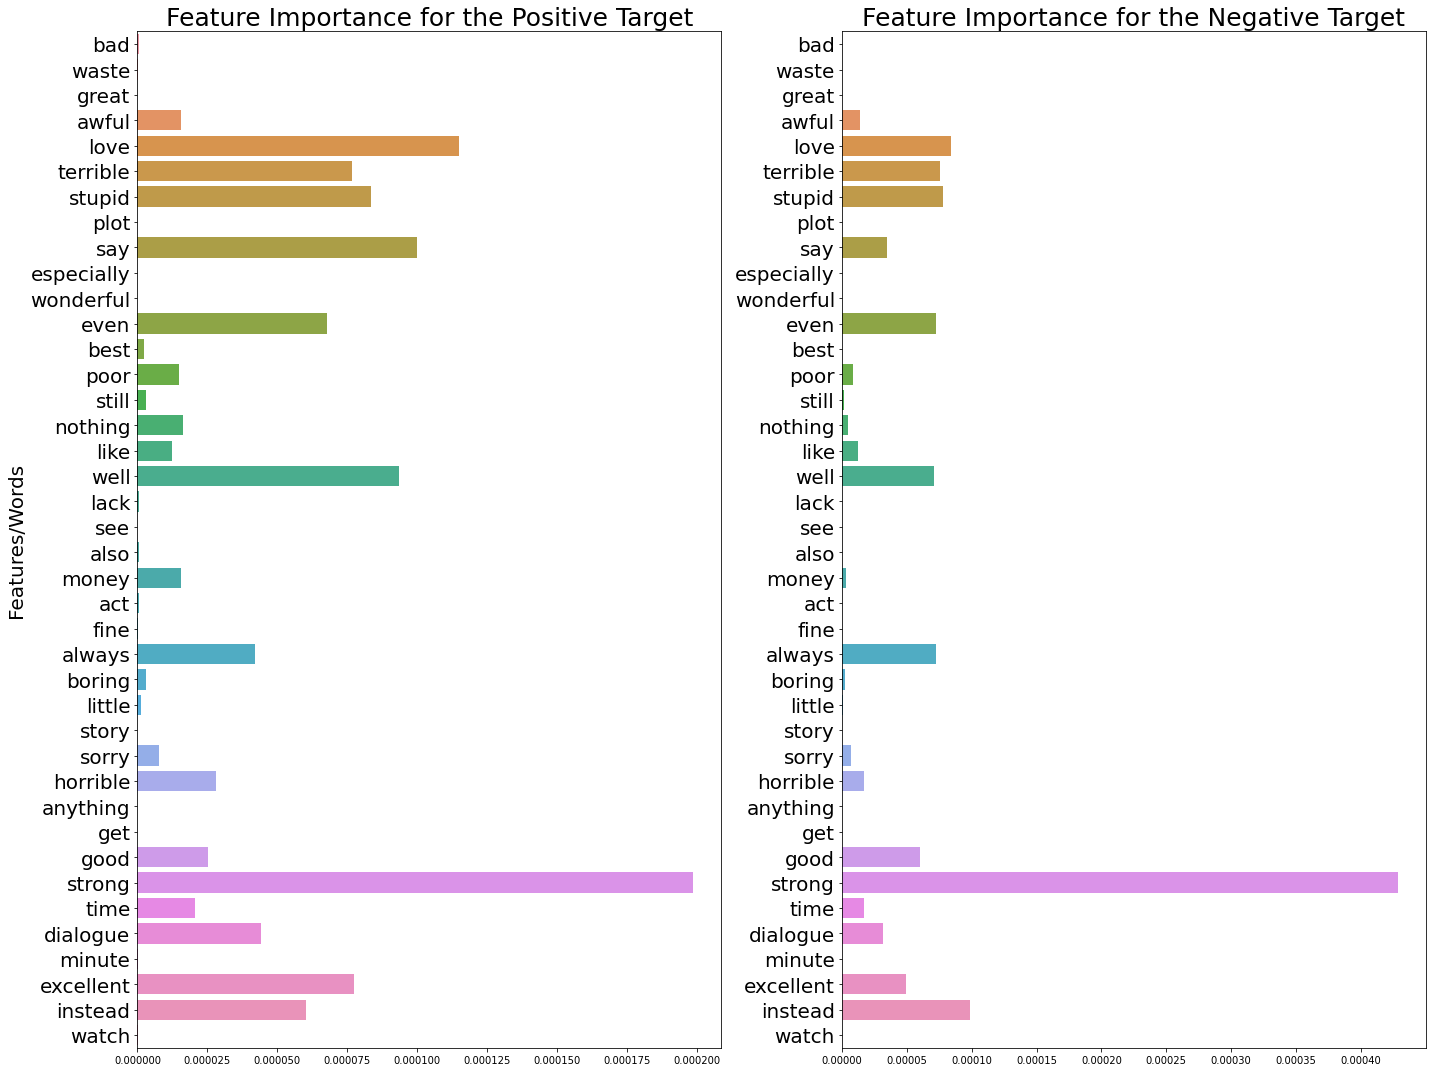

In [17]:
meplot.plot_var_imp_both_side(sample_vec, sample_label, sample_vec.columns, data, my_rf_model.feature_importances_, topn = 40)